# **Install packages and some useful outils**

In [ ]:
!pip install gymnasium
!pip install "gymnasium[all]"
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.* \
             PyOpenGL==3.1.* \
             PyOpenGL-accelerate==3.1.*

# Install virtual video device in colab
import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

# Check the virtual video device is available
!echo $DISPLAY

# **First example(lunar lander)**

### The code from website, see more: https://towardsdatascience.com/rendering-openai-gym-envs-on-binder-and-google-colab-536f99391cc7`

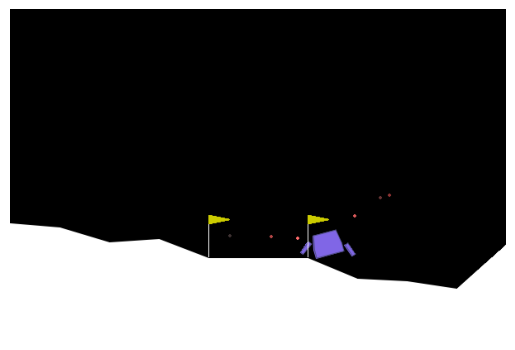

In [ ]:
import typing

import gym
import matplotlib.pyplot as plt
import numpy as np
from IPython import display


# represent states as arrays and actions as ints
State = np.ndarray
Action = int

# agent is just a function! 
Agent = typing.Callable[[State], Action]


def uniform_random_policy(state: State,
                          number_actions: int,
                          random_state: np.random.RandomState) -> Action:
    """Select an action at random from the set of feasible actions."""
    feasible_actions = np.arange(number_actions)
    probs = np.ones(number_actions) / number_actions
    action = random_state.choice(feasible_actions, p=probs)
    return action


def make_random_agent(number_actions: int,
                      random_state: np.random.RandomState = None) -> Agent:
    """Factory for creating an Agent."""
    _random_state = np.random.RandomState() if random_state is None else random_state
    return lambda state: uniform_random_policy(state, number_actions, _random_state)


def simulate(agent: Agent, env: gym.Env, ax: plt.Axes) -> None:
    state = env.reset()
    img = ax.imshow(env.render(mode='rgb_array'))
    done = False
    while not done:
        action = agent(state)
        img.set_data(env.render(mode='rgb_array')) 
        ax.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)       
    env.close()
    
# create the Gym environment
lunar_lander_v2 = gym.make('LunarLander-v2')
_ = lunar_lander_v2.seed(42)

# create an agent
random_agent = make_random_agent(lunar_lander_v2.action_space.n, random_state=None)

# simulate agent interacting with the environment
_, ax = plt.subplots(1, 1)
simulate(random_agent, lunar_lander_v2, ax)

### The code from tutorial, see more: https://gymnasium.farama.org/content/basic_usage/

In [ ]:
import gymnasium as gym

env = gym.make("LunarLander-v2")
observation, info = env.reset()

for i in range(1000):
  action = env.action_space.sample()
  observation, reward, terminated, truncated, info = env.step(action)

env.close()

# **Second example(FrozenLake)**

## Implement Q-learning to FrozenLake in gym

In [ ]:
# Import packages
import gymnasium as gym
import numpy as np

# Define the env we are going to use
env = gym.make("FrozenLake-v1")
print(env.reward_range)

# Initiliza the Q-table to store the state_action value
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Define the step_size(gamma) and epsilon
alpha_learningrate = 0.5
epsilon = 0.1
gamma_discount = 0.9

# Define a policy for this example
# Policy here is a ε-greedy policy
def policy(state, epsilon):
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  else:
    action = np.argmax(Q_table[state, :])
  return action

# Define a gain list to store all gain in all episodes
gain_list = []

# Start looping each episode and implement Q learning
def Q_learning(nb_episode, length_episode):
  for i in range(nb_episode):
    gain = 0
    # Initialize the start state
    observation, info = env.reset()

    for i in range(length_episode):
      old_observation = observation
      action = policy(old_observation, epsilon)
      observation, reward, terminated, truncated, info = env.step(action)
      Q_table[old_observation, action] = Q_table[old_observation, action] + alpha_learningrate*(reward + gamma_discount*np.max(Q_table[observation, :]) - Q_table[old_observation, action])
      gain += reward
      if terminated or truncated:
        break
    gain_list.append(gain)

env.close()

Q_learning(8000, 100)

(0, 1)


In [ ]:
env.observation_space.sample()

4

## Draw the trajectory for the updated Q_table using greedy policy

In [ ]:
import os
from PIL import Image
from IPython import display
import imageio
import numpy as np
import PIL.ImageDraw as ImageDraw
import matplotlib.pyplot as plt
from IPython.display import HTML

def _label_with_episode_number(frame, episode_num):
    im = Image.fromarray(frame)
    drawer = ImageDraw.Draw(im)
    if np.mean(im) < 128:
        text_color = (255,255,255)
    else:
        text_color = (0,0,0)
    #drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode_num+1}', fill=text_color)
    return im

frames = []

env = gym.make("FrozenLake-v1", render_mode='rgb_array')
observation, info = env.reset()
for i in range(100):
  action = policy(observation, 0)
  observation, reward, terminated, truncated, info = env.step(action)
  frame = env.render()
  frames.append(_label_with_episode_number(frame, episode_num=1))
  if terminated or truncated:
    break
env.close()

imageio.mimwrite(os.path.join('Trajectory_FozenLake.gif'), frames, fps=60)

# **Third example(Taxi)**

## Implement Q-learning to Taxi in gym

In [ ]:
# Import packages
import gymnasium as gym
import numpy as np

# Define the env we are going to use
env = gym.make("Taxi-v3")

# Initiliza the Q-table to store the state_action value
Q_table = np.random.random((env.observation_space.n, env.action_space.n))

# Define the step_size(gamma) and epsilon
alpha = 0.5
epsilon = 0.1
gamma = 1

# Define a policy for this example
def policy(state, epsilon):
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  else:
    action = np.argmax(Q_table[state, :])
  return action

# Define a gain list to store all gain in all episodes
gain_list = []

# Start looping each episode and implement Q learning
def Q_learning(nb_episode):
  for i in range(nb_episode):
    gain = 0
    # Initialize the start state
    observation, info = env.reset()

    while True:
      old_observation = observation
      action = policy(observation, epsilon)
      observation, reward, terminated, truncated, info = env.step(action)
      Q_table[old_observation, action] = Q_table[old_observation, action] + alpha*(reward + gamma*np.max(Q_table[observation, :]) - Q_table[old_observation, action])
      gain += reward
      if terminated or truncated:
        break
    gain_list.append(gain)

env.close()

Q_learning(1000)

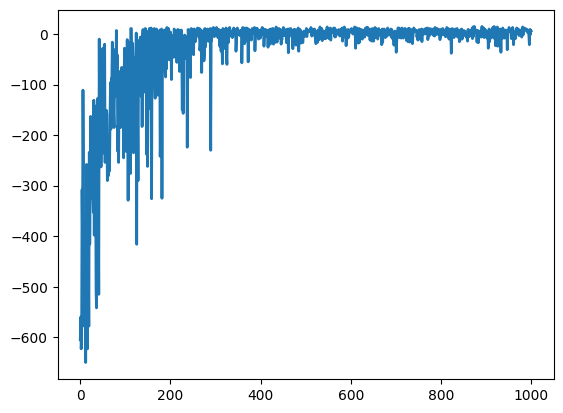

In [ ]:
# Plot the gain each episode
import matplotlib.pyplot as plt

x = np.linspace(0,1000,1000)
fig, ax = plt.subplots()
ax.plot(x, gain_list, linewidth=2.0)
plt.show()

## Draw the trajectory for the updated Q_table using greedy policy

In [ ]:
import os
from PIL import Image
from IPython import display
import imageio
import numpy as np
import PIL.ImageDraw as ImageDraw
import matplotlib.pyplot as plt
from IPython.display import HTML

env = gym.make("Taxi-v3", render_mode='rgb_array')
observation, info = env.reset()

def _label_with_episode_number(frame, episode_num):
    im = Image.fromarray(frame)
    drawer = ImageDraw.Draw(im)
    if np.mean(im) < 128:
        text_color = (255,255,255)
    else:
        text_color = (0,0,0)
    drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode_num+1}', fill=text_color)
    return im

frames = []
for i in range(100):
  action = policy(observation, 0.1)
  observation, reward, terminated, truncated, info = env.step(action)
  frame = env.render()
  frames.append(_label_with_episode_number(frame, episode_num=1))
  if terminated or truncated:
    break
env.close()

imageio.mimwrite(os.path.join('Trajectory_Taxi.gif'), frames, fps=120)

# **Forth example(BlackJack)**

## Implement Q-learning to BlackJack in gym

In [ ]:
# Import packages
import gymnasium as gym
import numpy as np

# Define the env we are going to use
env = gym.make("Blackjack-v1")

# Initiliza the Q-table to store the state_action value
Q_table = np.zeros((env.observation_space[0].n, env.observation_space[1].n, env.observation_space[2].n, env.action_space.n))

# Define the step_size(gamma) and epsilon
alpha = 0.5
epsilon = 0.1
gamma = 1

# Define a policy for this example
def policy(state, epsilon):
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  else:
    action = np.argmax(Q_table[state[0], state[1], state[2], :])
  return action

# Define a gain list to store all gain in all episodes
gain_list = []

# Start looping each episode and implement Q learning
def Q_learning(nb_episode):
  for i in range(nb_episode):
    gain = 0
    # Initialize the start state
    observation, info = env.reset()

    while True:
      old_observation = observation
      action = policy(observation, epsilon)
      observation, reward, terminated, truncated, info = env.step(action)
      Q_table[old_observation[0], old_observation[1], old_observation[2], action] = Q_table[old_observation[0], old_observation[1], old_observation[2], action] + alpha*(reward + gamma*np.max(Q_table[observation[0], observation[1], observation[2], :]) - Q_table[old_observation[0], old_observation[1], old_observation[2], action])
      gain += reward
      if terminated or truncated:
        break
    gain_list.append(gain)

env.close()

Q_learning(1000)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


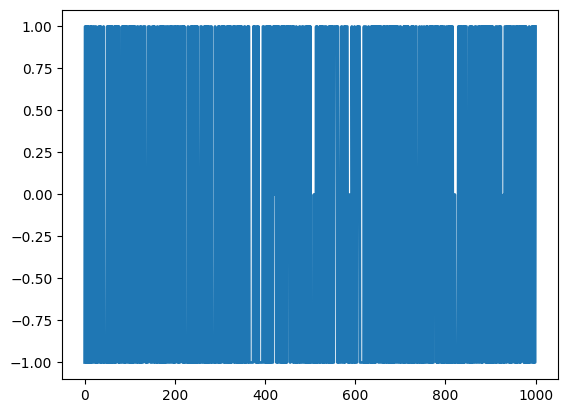

In [ ]:
# Plot the gain each episode
import matplotlib.pyplot as plt

x = np.linspace(0,1000,1000)
fig, ax = plt.subplots()
ax.plot(x, gain_list, linewidth=2.0)
plt.show()

## Draw the trajectory for the updated Q_table using greedy policy

In [ ]:
import os
from PIL import Image
from IPython import display
import imageio
import numpy as np
import PIL.ImageDraw as ImageDraw
import matplotlib.pyplot as plt
from IPython.display import HTML

env = gym.make("Blackjack-v1", render_mode='rgb_array')
observation, info = env.reset()

def _label_with_episode_number(frame, episode_num):
    im = Image.fromarray(frame)
    drawer = ImageDraw.Draw(im)
    if np.mean(im) < 128:
        text_color = (255,255,255)
    else:
        text_color = (0,0,0)
    drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode_num+1}', fill=text_color)
    return im

frames = []
for t in range(10):
  for i in range(100):
    observation, info = env.reset()
    action = policy(observation, 0.1)
    observation, reward, terminated, truncated, info = env.step(action)
    frame = env.render()
    frames.append(_label_with_episode_number(frame, episode_num=t))
    if terminated or truncated:
      break
env.close()

imageio.mimwrite(os.path.join('Trajectory_Blackjack.gif'), frames, fps=120)

# **Fifth example(Cliff walking)**

## Implement Q-learning to Cliff walking in gym

In [ ]:
# Import packages
import gymnasium as gym
import numpy as np

# Define the env we are going to use
env = gym.make("CliffWalking-v0")

# Initiliza the Q-table to store the state_action value
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Define the step_size(gamma) and epsilon
alpha_learningrate = 0.1
epsilon = 0.1
gamma_discount = 1

# Define a policy for this example
def policy(state, epsilon):
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  else:
    action = np.argmax(Q_table[state, :])
  return action

# Define a gain list to store all gain in all episodes
gain_list = []

# Start looping each episode and implement Q learning
def Q_learning(nb_episode):
  for i in range(nb_episode):
    gain = 0
    #print("Nb of episodes:" + str(i))
    # Initialize the start state
    observation, info = env.reset()

    while True:
      old_observation = observation
      action = policy(observation, epsilon)
      observation, reward, terminated, truncated, info = env.step(action)
      Q_table[old_observation, action] = Q_table[old_observation, action] + alpha_learningrate * (reward + gamma_discount * np.max(Q_table[observation, :]) - Q_table[old_observation, action])
      gain += reward
      if terminated or truncated:
        break
    #print("Episode " + str(i) + " finished")
    gain_list.append(gain)

env.close()

Q_learning(1000)

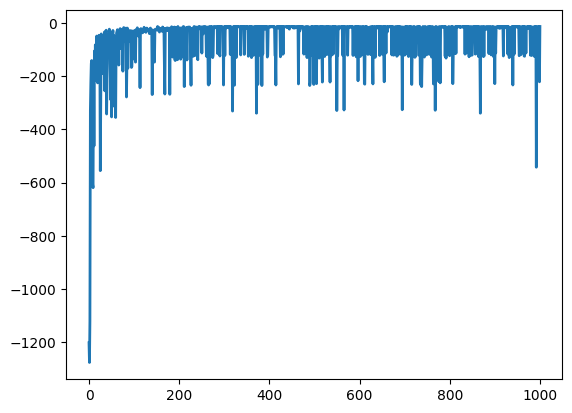

In [ ]:
# Plot the gain each episode
import matplotlib.pyplot as plt

x = np.linspace(0,1000,1000)
fig, ax = plt.subplots()
ax.plot(x, gain_list, linewidth=2.0)
plt.show()

## Draw the trajectory for the updated Q_table using greedy policy

In [ ]:
import os
from PIL import Image
from IPython import display
import imageio
import numpy as np
import PIL.ImageDraw as ImageDraw
import matplotlib.pyplot as plt
from IPython.display import HTML

env = gym.make("CliffWalking-v0", render_mode='rgb_array')
observation, info = env.reset()

def _label_with_episode_number(frame, episode_num):
    im = Image.fromarray(frame)
    drawer = ImageDraw.Draw(im)
    if np.mean(im) < 128:
        text_color = (255,255,255)
    else:
        text_color = (0,0,0)
    drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode_num+1}', fill=text_color)
    return im

for t in range(6):
  observation, info = env.reset()
  frames = []
  for i in range(100):
    action = policy(observation, 0.2)
    observation, reward, terminated, truncated, info = env.step(action)
    frame = env.render()
    frames.append(_label_with_episode_number(frame, episode_num=t))
    if terminated or truncated:
      break
env.close()

imageio.mimwrite(os.path.join('Trajectory_CliffWalk.gif'), frames, fps=120)

# **Deep Q learning**


In [ ]:
# Install used packages
import gymnasium as gym
import tensorflow as tf
import numpy as np
from tensorflow import keras

from collections import deque
import time
import random

from keras import layers

In [ ]:
# Environment here we use CartPole
env = gym.make('CartPole-v1')
nb_action = env.action_space.n

In [ ]:
# Define a Deep Q network who will take input the environment and output the Q-value of state
def DQN(state_shape, action_shape):
  learning_rate = 0.0001
  model = keras.Sequential(
      [
          layers.Dense(32, input_shape=state_shape, activation='relu', name='input_layer'),
          layers.Dense(16, activation='relu', name='hidden_layer_1'),
          layers.Dense(action_shape, activation='linear', name='output_layer'),
      ]
  )
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
  return model

In [ ]:
# Define a ε-greedy policy to select actions
def policy(state, model, epsilon):
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  else:
    predict = model(state.reshape([1,state.shape[0]]))
    action = np.argmax(predict)
  return action

In [ ]:
def train(replay_memory, predict_model, target_model, batch_size):
  # Define the learning_rate and discount_factor
  learning_rate = 5e-2
  discount_factor = 0.5

  # Using batch_size to sample experiences from replay_memory
  batch = random.sample(replay_memory, batch_size)

  # Get Q-value of current state using predict network
  current_state = np.array([S[0] for S in batch])
  current_state_Q = predict_model(current_state)
  # The output of the model is a tf.tensor, we here transform it 
  # to numpy array to make it easier to treat
  current_state_Q_update = current_state_Q.numpy()

  # Get Q-value for next state using target network
  next_state = np.array([S_next[3] for S_next in batch])
  next_state_Q = target_model(next_state)
  reward = np.array([reward[2] for reward in batch])

  for index, (observation, action, reward, new_observation, terminated) in enumerate(batch):
    if not terminated:
      target_Q = reward + discount_factor * np.max(next_state_Q[index])
    else:
      target_Q = reward

    current_state_Q_update[index, action] = (1 - learning_rate) * current_state[index, action] + learning_rate * target_Q

  predict_model.fit(current_state, current_state_Q_update, batch_size=batch_size, verbose=0, shuffle=True)

In [ ]:
def run_train():
  epsilon = 0.1
  
  # Define two model, one is target_model and one is predict_model
  # Initialize the weight
  predict_model = DQN(env.observation_space.shape, env.action_space.n)
  target_model = DQN(env.observation_space.shape, env.action_space.n)
  # First copy of weights between two model
  target_model.set_weights(predict_model.get_weights())

  # Define a rplay_memory and it's capacity
  replay_memory = deque(maxlen=50000)

  # Before we train the model, we need some experiences to store 
  # in replay_memory, otherwise we can't get experiences
  step_to_train_predict_model = 0
  step_to_update_target_model = 0

  train_episodes = 100

  # Loop for each episode
  for episode in range(train_episodes):
    reward_per_episode = 0
    observation, info = env.reset()
    done = False

    # Loop for each time step in one episode
    while not done:
      step_to_train_predict_model += 1

      # We use ε-greedy policy to select actions according to 
      # the Q-value calculed by predict_model.
      action = policy(state=observation, model=predict_model, epsilon=epsilon)

      # Take action and observe next state, reward, then add them
      # into the replay_memory, here I added also terminated signal
      # in order to use it in training 
      new_observation, reward, terminated, _, info = env.step(action)
      replay_memory.append([observation, action, reward, new_observation, terminated])

      # We train the model every 100 steps after, like first 
      # training we have 100 experiences stored in replay_memory, 
      # second train we have 200 experiences stored in replay_memory
      # etc.
      if step_to_train_predict_model > 100 and step_to_train_predict_model % 4 == 0:
        train(replay_memory, predict_model=predict_model, target_model=target_model, batch_size=50)

      # Here we update the target model's weight every 20 steps 
      # after updating the predict model
      if step_to_update_target_model > 100 and step_to_update_target_model % 20 == 0:
        target_model.set_weights(predict_model.get_weights())

      # Then state pass to next state and repeat the loop until
      # the ending of episode
      observation = new_observation

      reward_per_episode += reward

      done = terminated
    print("Reward for training episode " + str(episode) + " is " + str(reward_per_episode))
  
  env.close()
  return predict_model

In [ ]:
model = run_train()

In [ ]:
import os
from PIL import Image
from IPython import display
import imageio
import numpy as np
import PIL.ImageDraw as ImageDraw
import matplotlib.pyplot as plt
from IPython.display import HTML

env = gym.make("CartPole-v1", render_mode='rgb_array')
observation, info = env.reset()

def _label_with_episode_number(frame, episode_num):
    im = Image.fromarray(frame)
    drawer = ImageDraw.Draw(im)
    if np.mean(im) < 128:
        text_color = (255,255,255)
    else:
        text_color = (0,0,0)
    drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode_num+1}', fill=text_color)
    return im

frames = []
for t in range(1):
  for i in range(100):
    observation, info = env.reset()
    action = policy(state=observation, model=model, epsilon=0)
    observation, reward, terminated, truncated, info = env.step(action)
    frame = env.render()
    frames.append(_label_with_episode_number(frame, episode_num=t))
    if terminated or truncated:
      break
env.close()

imageio.mimwrite(os.path.join('CartPole_DQN.gif'), frames, fps=120)

# **Policy Gradient Methode in GYMNASIUM-CartPole_v1**

In [ ]:
!pip install mujoco==2.3.3

## Creating a RL using Policy Gradient Methode with CartPole in gym

In [ ]:
# Install used packages
import argparse
import gymnasium as gym
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import deque

# Packages for generate a gif to show the result
import os
from PIL import Image
from IPython import display
import imageio
import numpy as np
import PIL.ImageDraw as ImageDraw
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
class Policy(nn.Module):
  def __init__(self):
    super(Policy, self).__init__()
    self.input_layer = nn.Linear(4, 64)

    # Define the actor layer
    self.action = nn.Linear(64, 2)

  def forward(self, x):
    x = F.relu(self.input_layer(x))

    # Actor choses action to take from state by returning the prob of each action
    action_prob = F.softmax(self.action(x), dim=-1)

    # Return the probability
    return action_prob

In [ ]:
class Critic(nn.Module):
  def __init__(self):
    super(Critic, self).__init__()
    self.input_layer = nn.Linear(4, 64)

    # Define the value layer
    self.value = nn.Linear(64, 1)

  def forward(self, x):
    x = F.relu(self.input_layer(x))

    State_value = self.value(x)

    return State_value

In [ ]:
def select_action(model, state):
  state = torch.from_numpy(state).float().unsqueeze(0)
  probs = model(state)

  m = Categorical(probs)

  action = m.sample()

  return action.item(), m.log_prob(action)

In [ ]:
def train_model(state, new_state, reward, log_prob, terminated, policyModel, policy_optimizer, criticModel, stateval_optimizer):
  discount_rate = 0.7
  Reward = 0
  policy_losses = []
  state_value_losses = []
  I = 1

  state_tensor = torch.from_numpy(state).float().unsqueeze(0)
  next_state_tensor = torch.from_numpy(new_state).float().unsqueeze(0)
  
  current_state_value = criticModel(state_tensor)
  next_state_value = criticModel(next_state_tensor)

  if terminated:
    next_state_value = 0

  # Value Loss using MSE
  val_loss = F.mse_loss(reward + discount_rate * next_state_value, current_state_value)
  #val_loss *= I

  # Policy loss
  advantage = reward + discount_rate * next_state_value.item() - current_state_value.item()
  policy_loss = -log_prob * advantage
  policy_loss *= I

  # Backpropagate policy
  policy_optimizer.zero_grad()
  policy_loss.backward(retain_graph=True)
  policy_optimizer.step()

  # Backpropagate value
  stateval_optimizer.zero_grad()
  val_loss.backward()
  stateval_optimizer.step()

  I *= discount_rate

In [ ]:
def main():
  env = gym.make('CartPole-v1')
  env.reset(seed=42)
  # SavedAction = namedtuple('SavedAction', ['log_prob', 'Q_value'])
  nb_episode = 1000

  step_to_train_model = 0

  # Init model
  PolicyModel = Policy()
  CriticModel = Critic()

  #Init optimizer
  policy_optimizer = optim.SGD(PolicyModel.parameters(), lr=0.001)
  stateval_optimizer = optim.SGD(CriticModel.parameters(), lr=0.001)

  # Define a rplay_memory and it's capacity
  #replay_memory = deque(maxlen=50000)

  reward_list = []
  for i in range(nb_episode):

    state, _ = env.reset()
    episode_reward = 0

    for i in range(1000):
      # Select action from policy
      action, log_prob = select_action(model=PolicyModel, state=state)

      # Take action and observe St+1, reward
      new_state, reward, terminated, _, info = env.step(action)
      #replay_memory.append([observation, action, reward, new_state, terminated])

      episode_reward += reward

      if terminated:
        break
      
      #if step_to_train_model > 100 & step_to_train_model % 50 == 0:
      train_model(state, new_state, reward, log_prob, terminated, PolicyModel, policy_optimizer, CriticModel, stateval_optimizer)
      
      state = new_state
      episode_reward += reward
    reward_list.append(episode_reward)

  env.close()

  env = gym.make("CartPole-v1", render_mode='rgb_array')
  observation, info = env.reset()

  def _label_with_episode_number(frame, episode_num, step_num):
      im = Image.fromarray(frame)
      drawer = ImageDraw.Draw(im)
      if np.mean(im) < 128:
          text_color = (255,255,255)
      else:
          text_color = (0,0,0)
      #drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode_num+1}', fill=text_color)
      drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {step_num+1}', fill=text_color)
      return im

  frames = []
  for t in range(1):
    for i in range(1000):
      observation, info = env.reset()
      action, log_prob = select_action(model=PolicyModel, state=observation)
      observation, reward, terminated, truncated, info = env.step(action)
      frame = env.render()
      frames.append(_label_with_episode_number(frame, episode_num=t, step_num=i))
      if terminated or truncated:
        break
  env.close()

  imageio.mimwrite(os.path.join('CartPole_.gif'), frames, fps=120)

In [ ]:
if __name__ == "__main__":
  main()